# Assignment 1 for FIT5212, Semester 1, 2020

**Student Name:**  Meghna Khanna

**Student ID:**    29592445

## Part 1:  Text Classification

General comments and any shared processing here.

## Part 1 : Neural Network Method

## Importing Required Libraries 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

## Fast ai is a library that is mainly used for pretrained language models and fine tuning those models.

from fastai import *
from fastai.text import *  ## import this libarary to access functions of the text.data class to perform NLP tasks
from fastai.core import *


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-set/axcs_test.csv
/kaggle/input/train-set/axcs_train.csv


## Loading datasets

In [2]:
## Loading the training datasets using the pandas library function read_csv to load the dataset on to the working environment and using head() to have a glimpse of what the data is. 

train_set = pd.read_csv('/kaggle/input/train-set/axcs_train.csv')
train_set.head()

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,cs-9301111,arxiv.org/abs/cs/9301111,1989-12-31,Nested satisfiability,0,0,0,Nested satisfiability A special case of the s...
1,cs-9301112,arxiv.org/abs/cs/9301112,1990-03-31,A note on digitized angles,0,0,0,A note on digitized angles We study the confi...
2,cs-9301113,arxiv.org/abs/cs/9301113,1991-07-31,Textbook examples of recursion,0,0,0,Textbook examples of recursion We discuss pro...
3,cs-9301114,arxiv.org/abs/cs/9301114,1991-10-31,Theory and practice,0,0,0,Theory and practice The author argues to Sili...
4,cs-9301115,arxiv.org/abs/cs/9301115,1991-11-30,Context-free multilanguages,0,0,0,Context-free multilanguages This article is a...


In [3]:
## Reading the test data using the same pandas functions and head() this dataset will be used to check the accuracy of our classifier on unknown data, data that the classifier has not seen before

test_set = pd.read_csv('/kaggle/input/test-set/axcs_test.csv')
test_set.head()

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,no-150100335,arxiv.org/abs/1501.00335,2015-01-01,A Data Transparency Framework for Mobile Appli...,0.0,0.0,0.0,A Data Transparency Framework for Mobile Appl...
1,no-14024178,arxiv.org/abs/1402.4178,2015-01-01,A reclaimer scheduling problem arising in coal...,0.0,0.0,0.0,A reclaimer scheduling problem arising in coa...
2,no-150100263,arxiv.org/abs/1501.00263,2015-01-01,Communication-Efficient Distributed Optimizati...,0.0,0.0,1.0,Communication-Efficient Distributed Optimizat...
3,no-150100287,arxiv.org/abs/1501.00287,2015-01-01,Consistent Classification Algorithms for Multi...,0.0,0.0,0.0,Consistent Classification Algorithms for Mult...
4,no-11070586,arxiv.org/abs/1107.0586,2015-01-01,Managing key multicasting through orthogonal s...,0.0,0.0,0.0,Managing key multicasting through orthogonal ...


## Classifier - 1

### Building a neural network classfier to classify Math when provided with the Abstract

In [4]:
## Separating the columns Math and Abstract to train the classifier to learn features to predict the class as Maths if given an abstract or some text. 

train_Math= train_set[['Math','Abstract']]
train_Math.head()  ## Glimpse of the modified sliced dataset

,Math,Abstract
0,0,Nested satisfiability A special case of the s...
1,0,A note on digitized angles We study the confi...
2,0,Textbook examples of recursion We discuss pro...
3,0,Theory and practice The author argues to Sili...
4,0,Context-free multilanguages This article is a...


In [5]:
train_Math.shape  ## Validate the shape of the new dataset

(54731, 2)

In [6]:
## Perform the same operations on the test dataset to prepare it for processing in the language model and remove the NA values in the test set as there is only one NA value and it should 
## be removed and validate the shape of the dataset 

test_Math = test_set[['Math', 'Abstract']]  
test_Math= test_Math.dropna(how='all')
test_Math.shape

(19678, 2)

In [7]:
merged_df = pd.concat([train_Math, test_Math])  ## Merge the abstracts from test and train set to form a merged dataframe for the language model.

In [8]:
merged_df.head()  ## Check the view of the new dataframe

,Math,Abstract
0,0.0,Nested satisfiability A special case of the s...
1,0.0,A note on digitized angles We study the confi...
2,0.0,Textbook examples of recursion We discuss pro...
3,0.0,Theory and practice The author argues to Sili...
4,0.0,Context-free multilanguages This article is a...


## Data Preprocessing

#### Quickly assembling our data to make use of the fast ai library to build a language model in order to perform text classification. The library we use is the text.data library which is made available using the data_block api. We use the function called `TextLMDataBunch` that is used to get the data into a specfied model to parse to the language model. The parameters are the *path* which is a writable path in which the language model will be stored and then the training dataset  and validation dataset is merged_df that has all the text provided and the *device* is cuda to access the GPU so that the operations are faster and are done simultaneously.

In [9]:
## Storing the data structure in a variable called databunch.

data_bunch = TextLMDataBunch.from_df(path='/kaggle/working',train_df= merged_df,valid_df=merged_df, device='cuda')

#### Glimpse of the databunch just created, and it is displayed using the show_batch function. The sentences have been tokenized and as we can see tags have added to the words all special and grammatical characters have been retained. Since it is easier for the machine to interpret numbers the tokens that hav been generated have been replaced with the location of the token in the vocabulary. The voacbulary has been created when we create the databunch it encodes the tokens.

In [10]:
## Glimpse of the databunch that was just created using the show_batch function. 

data_bunch.show_batch()   

idx,text
0,"of recursion xxmaj we discuss properties of recursive schemas related to mccarthy 's ` ` 91 function ' ' and to xxmaj takeuchi 's triple recursion . xxmaj several theorems are proposed as interesting candidates for machine verification , and some intriguing open questions are raised . xxbos xxmaj theory and practice xxmaj the author argues to xxmaj silicon xxmaj valley that the most important and powerful part of computer"
1,"models and its application to belief revision and truth maintenance xxmaj we introduced decomposable negation normal form xxup dnnf recently as a tractable form of propositional theories , and provided a number of powerful logical operations that can be performed on it in polynomial time . xxmaj we also presented an algorithm for compiling any conjunctive normal form xxup cnf into xxup dnnf and provided a structure - based guarantee"
2,"soon as the program under consideration exploits more than a few processors over a long execution time . xxmaj this problem is addressed by the novel debugging tool dewiz ( xxmaj debugging xxmaj wizard ) , whose focus lies on scalability . dewiz has a modular , scalable architecture , and uses the event graph model as a representation of the investigated program . dewiz provides a set of modules"
3,"xxmaj toward xxmaj compact xxmaj interdomain xxmaj routing xxmaj this paper critically examines some propositions and arguments of cs . xxup ni / xxunk regarding applicability of hierarchical routing and perspectives of compact routing . xxmaj arguments against the former are found to be inaccurate while the latter is found to be equivalent to well - known deployed solutions . xxmaj also , multiple ( stacked ) application of compact"
4,algebraic xxmaj parametric xxmaj systems by xxmaj rectification of their xxmaj affine xxmaj expanded xxmaj lie xxmaj symmetries xxmaj lie group theory states that knowledge of a parameters solvable group of symmetries of a system of ordinary differential equations allows to reduce by the number of equations . xxmaj we apply this principle by finding some \ xxunk derivations } that induces \ xxunk } xxmaj lie point symmetries of


## Creating Language Model

#### Here we are using the pre-trained model `AWD_LSTM` which has been trained on the `wikitext` and has recorded the weights. The objective of creating a language learner is for contextualized learning and the lower representations of words in the text to give the text semantic meaning. This model is trained to predict the next word given a sequence of words and it is traiend in an unsupervised manner using `Recurrent Neural Networks(RNN)` to train the language model learner.

#### The learner has the parameters the data that is the databunch and name of the pre-trained model that will be downloaded from fastai and the directory where the learner model will be stored and drop_multi is a regularization parameter so we increase the penalization that is increase the paarmeter when the model is overfitting and decrease it when the model is underfitting.

In [11]:
learner = language_model_learner(data_bunch, AWD_LSTM, drop_mult=0.7, model_dir='/kaggle/working/')

#### Here we fit the learner model for 1 epoch and a learning rate of 1e-3 as the starting learning rate. We check the accuarcy, and loss in one epoch and as we see the accuracy is 32%. Here the learner is only training the last few layers of the RNN and the rest of the model and layers are left as it is, the last layers learn the weights of the new language and the reamining layers are the weights are the pre-trained model weights. We are training the learner to learn the new language that it has been presented with. The function fit_one_cycle is provided by fast_ai. We first just run for one epoch and check the accuracy.

In [12]:
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.296418,4.059570,0.320290,16:48


#### Next step is to unfreeze the all the layers and train all the layers, but before that we check if the learning rate we ahd used was of optimum value or not so we use a fastai function called lr_find() which finds the best learning rate value for the model.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


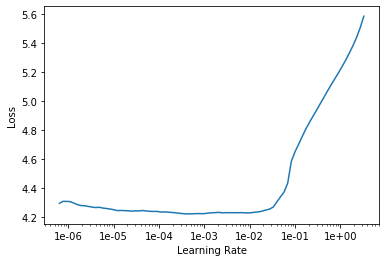

In [13]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

#### After plotting the loss at it each learning rate we can see that the learning rate skyrockets after 1e-3 the loss starts increasing if we set the learning rate to anything greater than the value.

#### <span style="color:red">  Now we fit the model to all the layers the pretrained layers and the new layers,the weights will be optimised as we are training on all the layers of the language learner and the accuracy increases by about 10% and the loss decreases with every epoch. We run fit_one_cycle() which consists of a callback to the OneCycleScheduler which uses the 1cycle policy. The 1cycle policy for Cyclical Learning Rates is that the learning rate exists within a reasonable mininum and maximum bounds basically the learning rate increases for one step and decreases for the other(one step consists of some iterations) so that incraeses the convergence and training time. This is used as low learning rate is too slow but it is accurate and a big learning rate crosses the sweet spot and diverges so to overcome this problem we use CLR. </span>

In [14]:
## the first parameter is epcoh, then learning rate value and last is the momentum parameter. The moms parameter is for the reason that when the learning rate is slow and we are going in 
## the same direction we might as well go faster and when the learning rate is high the momentum is slow as if we go fats we might overshoot the target that is why that is a parameter that
## should be specified.

learner.fit_one_cycle(4,1e-3,moms=(0.8,0.7))  

epoch,train_loss,valid_loss,accuracy,time
0,3.900353,3.712257,0.352785,16:56
1,3.738737,3.504561,0.371652,16:52
2,3.640990,3.403028,0.382557,16:51
3,3.566768,3.373935,0.385739,16:49


### Here we save the encoder to a writable folder and named it encoder.

In [15]:
learner.save_encoder('/kaggle/working/encoder')  ## Inbuilt function used save_encoder.

## RNN Classifier

#### Here we create a text data bunch only of the train set as here we are training the model to predict the class Math and we should not use the test set as we would be classifying ourselves. 

In [16]:
## The vocabulary learnt from the language data bunch is added as teh vocab parameter and bs is the batch size is 32 which is the size of the batch.
## Batch size bs to be used according to the GPU memory we have available, so for a 8GB GPU around bs=32 works fine. 


data_clas = TextClasDataBunch.from_df('./', train_df=train_Math, valid_df=train_Math, test_df= test_Math, vocab=data_bunch.train_ds.vocab, bs=32,device='cuda')

In [17]:
data_clas.show_batch()  ## Glimpse of the batch

text,target
"xxbos xxmaj some xxmaj extensions of xxmaj probabilistic xxmaj logic xxmaj in [ 12 ] , xxmaj nilsson proposed the probabilistic logic in which the truth values of logical propositions are probability values between 0 and 1 . xxmaj it is applicable to any logical system for which the consistency of a finite set of propositions can be established . xxmaj the probabilistic inference scheme reduces to the ordinary logical",0
"xxbos xxmaj magnetic xxmaj towers of xxmaj hanoi and their xxmaj optimal xxmaj solutions xxmaj the xxmaj magnetic xxmaj tower of xxmaj hanoi puzzle - a modified base 3 version of the classical xxmaj tower of xxmaj hanoi puzzle as described in earlier papers , is actually a small set of independent sister - puzzles , depending on the pre - coloring combination of the tower 's posts . xxmaj",1
"xxbos xxmaj the xxmaj complexity of xxmaj approximately xxmaj counting xxmaj tree xxmaj homomorphisms xxmaj we study two computational problems , parameterised by a fixed tree xxup h. # homsto(h ) is the problem of counting homomorphisms from an input graph g to xxup h. # whomsto(h ) is the problem of counting weighted homomorphisms to h , given an input graph g and a weight function for each vertex",0
"xxbos xxmaj multiscale xxmaj network xxmaj reduction xxmaj methodologies : xxmaj bistochastic and xxmaj disparity xxmaj filtering of xxmaj human xxmaj migration xxmaj flows between 3,000 + xxup u. xxup s. xxmaj counties xxmaj to control for multiscale effects in networks , one can transform the matrix of ( in general ) weighted , directed internodal flows to bistochastic ( doubly - stochastic ) form , using the iterative proportional",0
"xxbos xxmaj on xxmaj online xxmaj labeling with xxmaj polynomially xxmaj many xxmaj labels xxmaj in the online labeling problem with parameters n and m we are presented with a sequence of n keys from a totally ordered universe u and must assign each arriving key a label from the label set { 1,2, ... ,m } so that the order of labels ( strictly ) respects the ordering on",0


In [18]:
## Here we load our encoder that we had saved and create the classifier with the architecture of AWD_LSTM which has been pre-defined with pre-trained model that is provided by fastai.
## Regularization parameter is set as 0.5 which is usually the standard parameter.

classifier = text_classifier_learner(data_clas, arch= AWD_LSTM,drop_mult=0.5)
classifier.load_encoder('/kaggle/working/encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (54731 items)
x: TextList
xxbos xxmaj nested satisfiability a special case of the satisfiability problem , in which the clauses have a hierarchical structure , is shown to be solvable in linear time , assuming that the clauses have been represented in a convenient way .,xxbos a note on digitized angles xxmaj we study the configurations of pixels that occur when two digitized straight lines meet each other .,xxbos xxmaj textbook examples of recursion xxmaj we discuss properties of recursive schemas related to mccarthy 's ` ` 91 function ' ' and to xxmaj takeuchi 's triple recursion . xxmaj several theorems are proposed as interesting candidates for machine verification , and some intriguing open questions are raised .,xxbos xxmaj theory and practice xxmaj the author argues to xxmaj silicon xxmaj valley that the most important and powerful part of computer science is work that is simultaneously theoretical and practical . xxmaj he part

`The architecture AWD_LSTM stands for ASGD Weight Dropped LSTM where ASGD stands for Asynchronous Stochastic Gradient Descent and LSTM stands for Long Short Term memory.` `The reason we are using LSTM because it is one of the best structures for processing and learning sequential sequences and text classification.As here we have used the neural network for the` `language model too where we had to predict the next work given a few words in same window size. The AWD_LSTM is the pre-trained model consists an input dimension of the vocabulary and an` `output dimension of 300. It consists of weight dropout, RNN dropout, input, encoder dropout, dropout is a way to prevent the neural network from overfitting it is used as a regularization method.` </p>

In [19]:
classifier.fit_one_cycle(1, 1e-3)  ## Then we fit the classifier using fit_one_cycle for the last few layers.

epoch,train_loss,valid_loss,accuracy,time
0,0.297834,0.261391,0.888162,07:59


In [20]:
## Then unfreeze all the layers and apply the classifier to all the layers.


classifier.unfreeze()
classifier.fit_one_cycle(4,slice(1e-3/100,1e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.286334,0.249619,0.893698,08:42
1,0.283684,0.229864,0.902012,08:25
2,0.258860,0.208021,0.913340,08:33
3,0.242663,0.201602,0.916080,08:52


#### We will now chcek the accuracy on the test set and get the predictions using the get_preds function to get the prediction probabilities of teh abstract belonging to either class and the prediction labels. The parameters are the test dataset and whether the result should be ordered or not and then check what the probabilities are, as we can see for the first abstract the abstract has a probability of 0.99 of being 0 and 0.0018 of being 1 so it means it would belong to label 0.  

In [21]:
preds, target = classifier.get_preds(ds_type = DatasetType.Test, ordered=True) ## Used the inbuilt fastai function called get_preds which returns predictions and target class.
print('The preds as tensors is:',preds) 
preds = to_np(preds)  ## convert to an array for calculating the confusion matrix.
print('The preds after being converted to a numpy array',preds)  ## glimpse of the probabilities

The preds as tensors is: tensor([[0.9990, 0.0010],
        [0.9084, 0.0916],
        [0.6286, 0.3714],
        ...,
        [0.9883, 0.0117],
        [0.9943, 0.0057],
        [0.9470, 0.0530]])
The preds after being converted to a numpy array [[9.989763e-01 1.023624e-03]
 [9.083822e-01 9.161775e-02]
 [6.286176e-01 3.713823e-01]
 [9.067446e-01 9.325535e-02]
 ...
 [9.995346e-01 4.654611e-04]
 [9.882807e-01 1.171937e-02]
 [9.943182e-01 5.681822e-03]
 [9.470031e-01 5.299699e-02]]


In [22]:
y_test=test_set['Math'].dropna(how='all')
y_test.shape

(19678,)

In [23]:
## Create a function to get the predicted labels for the abstracts in the test dataset. If the probability of it lying in class '0' is higher than it lying in class '1' then the abstract would
## lie in class 0 and vice-versa.


def get_label(preds):
    if preds[0] > preds[1]:
        return 0.0
    else:
        return 1.0

In [24]:
## Create a list for all the predicted labels in order to calculate the confusion matrix so append all the labels calculated using the function get_label to y_predict/


y_predict = list()    

for prediction in preds:
    y_predict.append(get_label(prediction))
y_predict

[0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0

### Confusion Matrix

Imported the libraries sklearn.metrics to calculate the metrics for a classification model such as the true positives and negatives and false negatives and positives, the precision.   

$$Precision = \frac{True Postive}{True Positive + True negative}$$<br>
$$= \frac{True Positive}{Total Predicted Positive}$$ <br>

`Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive.It is a good measure to determine when the costs of False Positive are high that means values that are actually positive but classified as negative.`

$$Recall = \frac{True Positive}{True Positive + False Positive}$$ <br>
$$ = \frac{True Positive}{Total Actual Positive}$$ <br>


`Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive).It is a good metric when the cost is high associated with False Negative.`

$$F1\ Score  = 2 \times \frac{precision \times recall}{precision + recall}$$
<br>
`Is a good metric when we want an even class distribution or a way to seek good balance of true negatives and true positives as the accuracy is mostly attributed by classifying true negatives more than true positives.`

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
def confusionmatrix(y_predict,y_test):
    

    y_predict = np.asarray(y_predict)
    y_test = np.asarray(y_test)
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    return('Confusion Matrix:', confusion_matrix(y_test,y_predict),'Accuracy: '+ str(accuracy),'Macro Precision: '+ str(precision),'Macro Recall: '+ str(recall),\
    'Macro F1 score:'+ str(f1score),'MCC:'+ str(matthews))

confusionmatrix(y_predict,y_test)

('Confusion Matrix:',
 array([[12692,  1056],
        [ 1214,  4716]]),
 'Accuracy: 0.884642748246773',
 'Macro Precision: 0.8648736855985526',
 'Macro Recall: 0.8592335368357733',
 'Macro F1 score:0.8619651457099637',
 'MCC:0.7240852562395453')

## Classifier - 2(CompVis)

In [26]:
train_comp= train_set[['CompVis','Abstract']]
train_comp.head()  ## Glimpse of the modified sliced dataset

,CompVis,Abstract
0,0,Nested satisfiability A special case of the s...
1,0,A note on digitized angles We study the confi...
2,0,Textbook examples of recursion We discuss pro...
3,0,Theory and practice The author argues to Sili...
4,0,Context-free multilanguages This article is a...


In [27]:
test_comp = test_set[['CompVis', 'Abstract']]  
test_comp= test_comp.dropna(how='all')
test_comp.shape

(19678, 2)

## RNN Classifier

In [28]:
data_clas_comp = TextClasDataBunch.from_df('./', train_df=train_comp, valid_df=train_comp, test_df= test_comp, vocab=data_bunch.train_ds.vocab, bs=32,device='cuda')

In [29]:
data_clas_comp.show_batch()  ## Glimpse of the batch

text,target
"xxbos xxmaj some xxmaj extensions of xxmaj probabilistic xxmaj logic xxmaj in [ 12 ] , xxmaj nilsson proposed the probabilistic logic in which the truth values of logical propositions are probability values between 0 and 1 . xxmaj it is applicable to any logical system for which the consistency of a finite set of propositions can be established . xxmaj the probabilistic inference scheme reduces to the ordinary logical",0
xxbos xxmaj packing 3-vertex paths in claw - free graphs and related topics xxmaj an l - factor of a graph g is a spanning subgraph of g whose every component is a 3-vertex path . xxmaj let v(g ) be the number of vertices of g and d(g ) the domination number of xxup g. a claw is a graph with four vertices and three edges incident to the,0
"xxbos xxmaj subspace xxmaj alignment xxmaj chains and the xxmaj degrees of xxmaj freedom of the xxmaj three - xxmaj user xxup mimo xxmaj interference xxmaj channel xxmaj we show that the 3 user xxup m_t x xxup m_r xxup mimo interference channel has d(m , xxunk / ( 2 - 1 / xxunk / ( 2 + 1 / k ) ) degrees of freedom ( dof ) normalized",0
"xxbos xxmaj identification de r \ ^oles xxunk dans des r \ ' eseaux orient \ ' es appliqu \ ' ee \ ` a xxmaj twitter xxmaj the notion of community structure is particularly useful when analyzing complex networks , because it provides an intermediate level , compared to the more classic global ( whole network ) and local ( node neighborhood ) approaches . xxmaj the concept of",0
"xxbos xxmaj approximation xxmaj algorithms for xxmaj orienteering with xxmaj time xxmaj windows xxmaj orienteering is the following optimization problem : given an edge - weighted graph ( directed or undirected ) , two nodes s , t and a time limit t , find an s - t walk of total length at most t that maximizes the number of distinct nodes visited by the walk . xxmaj one",0


In [30]:
classifier_comp = text_classifier_learner(data_clas_comp, arch= AWD_LSTM,drop_mult=0.5)
classifier_comp.load_encoder('/kaggle/working/encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (54731 items)
x: TextList
xxbos xxmaj nested satisfiability a special case of the satisfiability problem , in which the clauses have a hierarchical structure , is shown to be solvable in linear time , assuming that the clauses have been represented in a convenient way .,xxbos a note on digitized angles xxmaj we study the configurations of pixels that occur when two digitized straight lines meet each other .,xxbos xxmaj textbook examples of recursion xxmaj we discuss properties of recursive schemas related to mccarthy 's ` ` 91 function ' ' and to xxmaj takeuchi 's triple recursion . xxmaj several theorems are proposed as interesting candidates for machine verification , and some intriguing open questions are raised .,xxbos xxmaj theory and practice xxmaj the author argues to xxmaj silicon xxmaj valley that the most important and powerful part of computer science is work that is simultaneously theoretical and practical . xxmaj he part

In [31]:
classifier_comp.fit_one_cycle(1, 1e-3)  ## Then we fit the classifier using fit_one_cycle for the last few layers.

epoch,train_loss,valid_loss,accuracy,time
0,0.070323,0.042031,0.985822,08:09


In [32]:
classifier_comp.unfreeze()
classifier_comp.fit_one_cycle(4,slice(1e-3/100,1e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.059373,0.040079,0.985694,08:59
1,0.034576,0.029211,0.989275,08:18
2,0.033808,0.022579,0.991431,08:44
3,0.029379,0.020077,0.992527,08:20


In [33]:
preds_comp, target_comp = classifier_comp.get_preds(ds_type = DatasetType.Test, ordered=True)


In [34]:
y_predict_comp=list()

for comp in preds_comp:
    y_predict_comp.append(get_label(comp))
y_predict_comp

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [35]:
y_test_comp= test_set['CompVis'].dropna(how='all')
y_test_comp.shape

(19678,)

In [36]:
confusionmatrix(y_predict_comp,y_test_comp)

('Confusion Matrix:',
 array([[17396,   130],
        [  326,  1826]]),
 'Accuracy: 0.9768269133041976',
 'Macro Precision: 0.9575713086619083',
 'Macro Recall: 0.9205477300427152',
 'Macro F1 score:0.9380300873244902',
 'MCC:0.8773381906435854')

## Classifier - 3 (InfoTheory)

In [37]:
train_info= train_set[['InfoTheory','Abstract']]
train_info.head()  ## Glimpse of the modified sliced dataset

,InfoTheory,Abstract
0,0,Nested satisfiability A special case of the s...
1,0,A note on digitized angles We study the confi...
2,0,Textbook examples of recursion We discuss pro...
3,0,Theory and practice The author argues to Sili...
4,0,Context-free multilanguages This article is a...


In [38]:
test_info = test_set[['InfoTheory', 'Abstract']]  
test_info= test_info.dropna(how='all')
test_info.shape

(19678, 2)

## RNN Classifier

In [39]:
data_clas_info = TextClasDataBunch.from_df('./', train_df=train_info, valid_df=train_info, test_df= test_info, vocab=data_bunch.train_ds.vocab, bs=32,device='cuda')

In [40]:
data_clas_info.show_batch()  ## Glimpse of the batch

text,target
"xxbos xxmaj some xxmaj extensions of xxmaj probabilistic xxmaj logic xxmaj in [ 12 ] , xxmaj nilsson proposed the probabilistic logic in which the truth values of logical propositions are probability values between 0 and 1 . xxmaj it is applicable to any logical system for which the consistency of a finite set of propositions can be established . xxmaj the probabilistic inference scheme reduces to the ordinary logical",0
xxbos xxmaj packing 3-vertex paths in claw - free graphs and related topics xxmaj an l - factor of a graph g is a spanning subgraph of g whose every component is a 3-vertex path . xxmaj let v(g ) be the number of vertices of g and d(g ) the domination number of xxup g. a claw is a graph with four vertices and three edges incident to the,0
"xxbos xxmaj subspace xxmaj alignment xxmaj chains and the xxmaj degrees of xxmaj freedom of the xxmaj three - xxmaj user xxup mimo xxmaj interference xxmaj channel xxmaj we show that the 3 user xxup m_t x xxup m_r xxup mimo interference channel has d(m , xxunk / ( 2 - 1 / xxunk / ( 2 + 1 / k ) ) degrees of freedom ( dof ) normalized",1
"xxbos xxmaj identification de r \ ^oles xxunk dans des r \ ' eseaux orient \ ' es appliqu \ ' ee \ ` a xxmaj twitter xxmaj the notion of community structure is particularly useful when analyzing complex networks , because it provides an intermediate level , compared to the more classic global ( whole network ) and local ( node neighborhood ) approaches . xxmaj the concept of",0
"xxbos xxmaj approximation xxmaj algorithms for xxmaj orienteering with xxmaj time xxmaj windows xxmaj orienteering is the following optimization problem : given an edge - weighted graph ( directed or undirected ) , two nodes s , t and a time limit t , find an s - t walk of total length at most t that maximizes the number of distinct nodes visited by the walk . xxmaj one",0


In [41]:
classifier_info = text_classifier_learner(data_clas_info, arch= AWD_LSTM,drop_mult=0.5)
classifier_info.load_encoder('/kaggle/working/encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (54731 items)
x: TextList
xxbos xxmaj nested satisfiability a special case of the satisfiability problem , in which the clauses have a hierarchical structure , is shown to be solvable in linear time , assuming that the clauses have been represented in a convenient way .,xxbos a note on digitized angles xxmaj we study the configurations of pixels that occur when two digitized straight lines meet each other .,xxbos xxmaj textbook examples of recursion xxmaj we discuss properties of recursive schemas related to mccarthy 's ` ` 91 function ' ' and to xxmaj takeuchi 's triple recursion . xxmaj several theorems are proposed as interesting candidates for machine verification , and some intriguing open questions are raised .,xxbos xxmaj theory and practice xxmaj the author argues to xxmaj silicon xxmaj valley that the most important and powerful part of computer science is work that is simultaneously theoretical and practical . xxmaj he part

In [42]:
classifier_info.fit_one_cycle(1, 1e-3)  ## Then we fit the classifier using fit_one_cycle for the last few layers.

epoch,train_loss,valid_loss,accuracy,time
0,0.155275,0.114495,0.957848,08:18


In [43]:
classifier_info.unfreeze() ###
classifier_info.fit_one_cycle(4,slice(1e-3/100,1e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.154921,0.112431,0.959127,09:12
1,0.143364,0.091645,0.967532,08:29
2,0.111311,0.077017,0.972283,08:45
3,0.099871,0.073684,0.973324,08:21


In [44]:
preds_info, target_info = classifier_info.get_preds(ds_type = DatasetType.Test, ordered=True)


In [45]:
preds

array([[9.989763e-01, 1.023624e-03],
       [9.083822e-01, 9.161775e-02],
       [6.286176e-01, 3.713823e-01],
       [9.067446e-01, 9.325535e-02],
       ...,
       [9.995346e-01, 4.654611e-04],
       [9.882807e-01, 1.171937e-02],
       [9.943182e-01, 5.681822e-03],
       [9.470031e-01, 5.299699e-02]], dtype=float32)

In [46]:
predict_info=list()

for info in preds_info:
    predict_info.append(get_label(info))
predict_info

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [47]:
y_test_info= test_set['InfoTheory'].dropna(how='all')
y_test_info.shape

(19678,)

In [48]:
confusion_matrix=confusionmatrix(predict_info,y_test_info)

In [49]:
confusion_matrix

('Confusion Matrix:',
 array([[15765,   297],
        [  490,  3126]]),
 'Accuracy: 0.9600060981807094',
 'Macro Precision: 0.941544717178642',
 'Macro Recall: 0.9230001512391695',
 'Macro F1 score:0.9319209189099058',
 'MCC:0.8643459542230111')

### Part 1: Machine Learning Method

Details of method

In [ ]:
import pandas as pd

In [ ]:
import pandas as pd

## Part 2: Topic Modelling

General comments and any shared processing here.